In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from unagi import config
from unagi import hsc
from unagi import mask
from unagi import plotting
from unagi.task import hsc_cutout, hsc_tricolor

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [3]:
from caterpillar import catalog

## Test the Dynamical Cutout Size for HSC Dwarf Candidates

In [11]:
# Remove all the `isnull` columns
# Only needs to do this once

# cat_g09 = catalog.remove_is_null(os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H.fits'), return_data=True)

Reading the data....
Saving data to None ...


In [41]:
merian_dir = '/Users/song/Downloads/merian/'

pdr2_g09_cat = os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H.fits')
pdr2_g09 = Table.read(pdr2_g09_cat)

print(len(pdr2_g09))

3049545


In [42]:
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_sdss_shape', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09 = catalog.moments_to_shape(pdr2_g09, shape_type='r_cmodel_ellipse', update=True)

#### Filter through bright star mask

In [8]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

pdr2_g09_bsm = catalog.filter_through_bright_star_mask(pdr2_g09_cat, mask_dir)

In [43]:
pdr2_g09_bsm = Table.read(os.path.join(merian_dir, 'catalog', 'Broadcut_GAMA09H_bsm.fits'))

print(len(pdr2_g09_bsm))

1906179


In [44]:
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_sdss_shape', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09_bsm = catalog.moments_to_shape(pdr2_g09_bsm, shape_type='r_cmodel_ellipse', update=True)

#### Get the objects within the bright star masks

In [45]:
pdr2_g09_msk = catalog.filter_through_bright_star_mask(
    pdr2_g09_cat, mask_dir, filter_type='inside', output_suffix='masked')

In [50]:
print(len(pdr2_g09_msk))

pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_sdss_shape', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='i_cmodel_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_g09_msk = catalog.moments_to_shape(pdr2_g09_msk, shape_type='r_cmodel_ellipse', update=True)

950602


#### Spatial distributions of objects

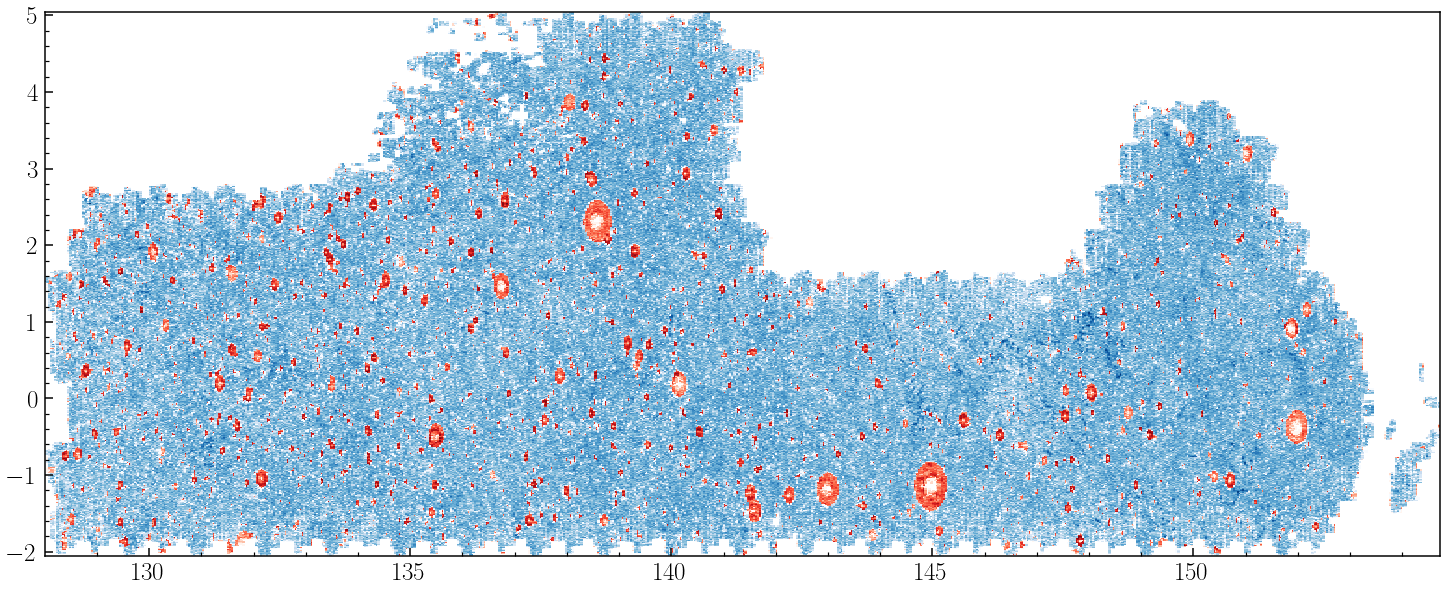

In [48]:
plt.figure(figsize=(25, 10))

_ = plt.hist2d(pdr2_g09['ra'], pdr2_g09['dec'], bins=(750, 550), norm=mpl.colors.LogNorm(),
               cmap='Reds', edgecolor='none')

_ = plt.hist2d(pdr2_g09_bsm['ra'], pdr2_g09_bsm['dec'], bins=(750, 550), alpha=1.0, 
               norm=mpl.colors.LogNorm(), cmap='Blues', edgecolor='none')

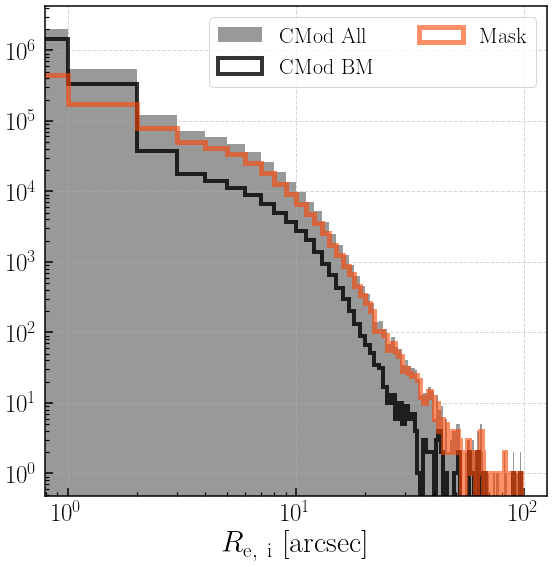

In [51]:
plt.figure(figsize=(9, 9))
plt.loglog()

_ = plt.hist(pdr2_g09['i_cmodel_exp_ellipse_r'], range=(0, 100), bins=100, color='grey', alpha=0.8, 
             label=r'$\rm CMod\ All$')

_ = plt.hist(pdr2_g09_bsm['i_cmodel_exp_ellipse_r'], range=(0, 100), bins=100, color='k', alpha=0.8, 
             histtype='step', linewidth=4, label=r'$\rm CMod\ BM$')

_ = plt.hist(pdr2_g09_msk['i_cmodel_exp_ellipse_r'], range=(0, 100), bins=100, histtype='step', 
             color='orangered', linewidth=5, alpha=0.6, label=r'$\rm Mask$')

plt.legend(fontsize=22, ncol=2)

_ = plt.xlabel(r'$R_{\rm e,\ i}\ [\rm arcsec]$', fontsize=30)

Text(0, 0.5, '$\\log\\ (R_{\\rm CMod,\\ Exp,\\ i}/[\\rm arcsec])$')

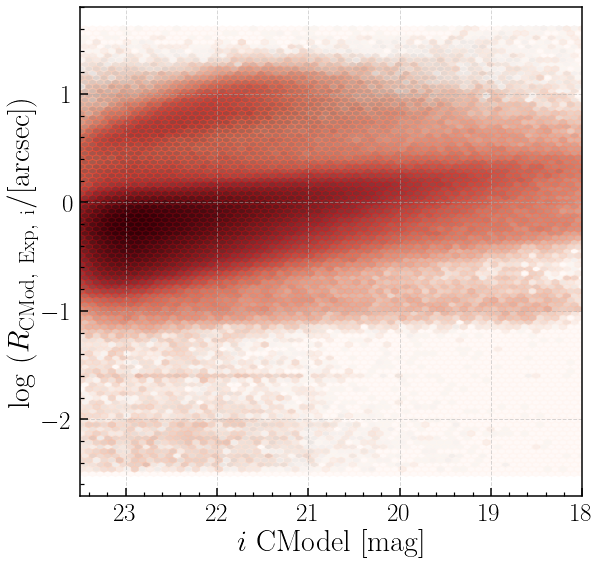

In [39]:
plt.figure(figsize=(9, 9))

_ = plt.hexbin(cat_g09['i_cmodel_mag'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']), 
           extent=(17.5, 24.2, -2.5, 1.6), cmap='Greys', bins='log', gridsize=(80, 50))

_ = plt.hexbin(cat_g09_bsm['i_cmodel_mag'], np.log10(cat_g09_bsm['i_cmodel_exp_ellipse_r']), 
           extent=(17.5, 24.2, -2.5, 1.6), cmap='Reds', bins='log', gridsize=(80, 50), alpha=0.5)

plt.xlim(23.5, 18.0)

plt.xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
plt.ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

<ipython-input-14-68044642c9bc>:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hexbin(cat_g09['photoz_mean'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']),


Text(0, 0.5, '$\\log\\ (R_{\\rm CMod,\\ Exp,\\ i}/[\\rm arcsec])$')

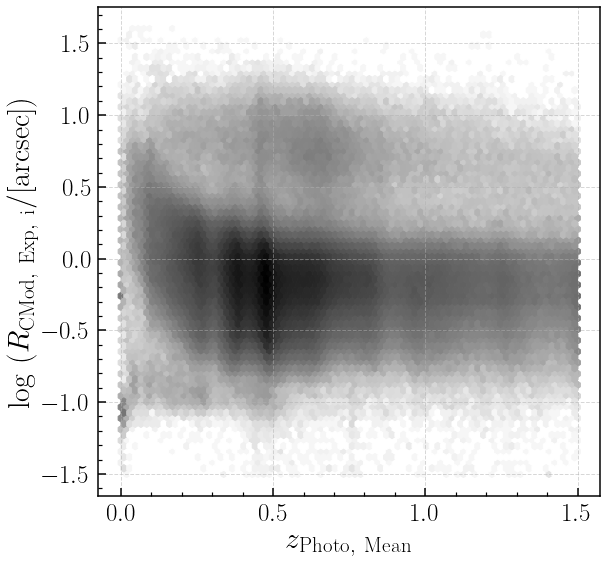

In [14]:
plt.figure(figsize=(9, 9))

plt.hexbin(cat_g09['photoz_mean'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']), 
           extent=(0, 1.5, -1.5, 1.6), vmin=1, cmap='Greys', bins='log', gridsize=(80, 40))

plt.xlabel(r'$z_{\rm Photo,\ Mean}$', fontsize=30)
plt.ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

In [17]:
large_flag = np.log10(cat_g09['i_cmodel_exp_ellipse_r']) >= 0.5
small_flag = (np.log10(cat_g09['i_cmodel_exp_ellipse_r']) <= -0.8) & (cat_g09['i_cmodel_mag'] <= 22.0)

large_flag.sum(), small_flag.sum()

(72354, 6556)

In [79]:
sample_1 = cat_g09[~large_flag]
sample_2 = cat_g09[large_flag]
sample_3 = cat_g09[small_flag]

In [80]:
random_1 = Table(np.random.choice(sample_1, 200, replace=False))
random_2 = Table(np.random.choice(sample_2, 100, replace=False))
random_3 = Table(np.random.choice(sample_3, 100, replace=False))

<ipython-input-85-b2f489035bdf>:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.hexbin(cat_g09['i_cmodel_mag'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']),


Text(0, 0.5, '$\\log\\ (R_{\\rm CMod,\\ Exp,\\ i}/[\\rm arcsec])$')

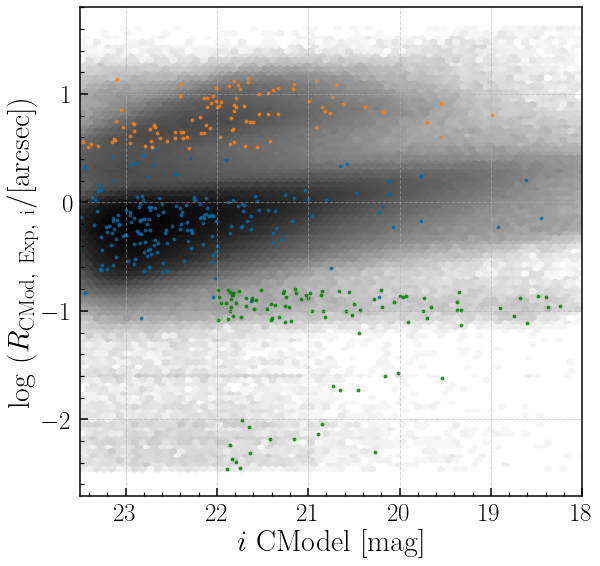

In [85]:
plt.figure(figsize=(9, 9))

plt.hexbin(cat_g09['i_cmodel_mag'], np.log10(cat_g09['i_cmodel_exp_ellipse_r']), 
           extent=(17.5, 24.2, -2.5, 1.6), vmin=1, cmap='Greys', bins='log', gridsize=(80, 50))

plt.scatter(random_1['i_cmodel_mag'], np.log10(random_1['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8)
plt.scatter(random_2['i_cmodel_mag'], np.log10(random_2['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8)
plt.scatter(random_3['i_cmodel_mag'], np.log10(random_3['i_cmodel_exp_ellipse_r']), s=8, alpha=0.8, c='g')

plt.xlim(23.5, 18.0)

plt.xlabel(r'$i\ \rm CModel\ [mag]$', fontsize=30)
plt.ylabel(r'$\log\ (R_{\rm CMod,\ Exp,\ i}/[\rm arcsec])$', fontsize=30)

In [117]:
def show_obj(obj, archive=pdr2):
    """Show 3-Color picture"""
    coord = SkyCoord(obj['ra'], obj['dec'], unit='deg')
    
    # Angular size
    s_ang = 10.0 * obj['i_cmodel_exp_ellipse_r']
    s_ang = s_ang if s_ang <= 20 else 20
    s_ang = s_ang if s_ang >= 3 else 3

    cutout_rgb, cutout_wcs = hsc_tricolor(
        coord, cutout_size=s_ang, filters='gri', verbose=False, 
        save_rgb=False, save_img=False, use_saved=False, archive=pdr2)
    
    return plotting.display_single(cutout_rgb)

In [122]:
random_1.write(os.path.join(merian_dir, 'catalog', 'random_1', 'random_1.fits'), overwrite=True)

for ii, obj in enumerate(random_1):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_1', 'random_1_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)

In [123]:
random_2.write(os.path.join(merian_dir, 'catalog', 'random_2', 'random_2.fits'), overwrite=True)

for ii, obj in enumerate(random_2):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_2', 'random_2_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)

In [124]:
random_3.write(os.path.join(merian_dir, 'catalog', 'random_3', 'random_3.fits'), overwrite=True)

for ii, obj in enumerate(random_3):    
    fig = show_obj(obj)
    fig.savefig(
        os.path.join(merian_dir, 'catalog', 'random_3', 'random_3_obj_{:d}.png'.format(ii + 1)))
    plt.close(fig)
